In [1]:
import torch
import numpy as np
import cv2
import best.singular_point as sp
from teste_util import *
import teste_util as TS

# Fixar a semente do Torch para operações específicas
fixed_seed()

# leitura dos dados
trainloader,testloader =read_dataload_flower(sp.args.img_size,'./data/datasets')
iterator=iter(testloader)
img,labels = next(iterator)
print(img.shape,labels.shape)

# Carregar o modelo singular points
path_siamese = './data/models/sp_map_fo_30.pth'
sp.args.num_channels = 1
model = sp.SingularPoints(args=sp.args).to(sp.device)
load_model(model,path_siamese,sp.device)

#gerar variacao de transformacoes pespectivas e fotometrica
params_lists =AugmentationParamsGenerator(6,img.shape)


torch.Size([60, 1, 120, 120]) torch.Size([60])
Namespace(exported=False, num_channels=1, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=12, box_size=21, nms_size=5, img_size=120, batch_size=16, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)


/home/wagner/.local/lib/python3.11/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Model loaded from ./data/models/sp_map_fo_30.pth


## Processo de detecção e correspondencia com kornia

In [2]:
from kornia.feature import *
# device = torch.device('cpu')
device = torch.device('cuda:0')
PS = 19 # patch size
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = sift
resp = BlobHessian()
scale_pyr = kornia.geometry.ScalePyramid(1, 1.3, PS, double_image=True)
print('scale_pyr ',scale_pyr)
nms = kornia.geometry.ConvQuadInterp3d(15)
n_features = 60

detector = ScaleSpaceDetector(n_features,
                              resp_module=resp,
                              nms_module=nms,
                              scale_pyr_module=scale_pyr,
                              ori_module=kornia.feature.LAFOrienter(PS),
                              minima_are_also_good=True,
                              mr_size=6.0).to(device)

scale_pyr  ScalePyramid(n_levels=1, init_sigma=1.3, min_size=19, extra_levels=3, border=8, sigma_step=2.0, double_image=True)


In [3]:
def detect_and_extract_features(image, detector, descriptor, PS):
    with torch.no_grad():
        lafs, resps = detector(image[None])
        # print('lafs ',lafs.shape,' resps ',resps.shape,' image ',image[None].shape)
        patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, PS)
        B, N, CH, H, W = patches.size()
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        return lafs, descs
    
def detect_extract_feat_in_batch(batch_img, detector, descriptor, PS):
    repo_lafs_desc = []
    with torch.no_grad():
        for image  in batch_img:            
            lafs, resps = detector(image[None])
            patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, PS)

            B, N, CH, H, W = patches.size()
            print("detect_extract_feat_in_batch ",B, N, CH, H, W,patches.view(B * N, CH, H, W).shape)
            
            descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
            repo_lafs_desc.append((lafs,descs))
            
    return repo_lafs_desc

def matching_imagens(ref_img,batch_img, repo_lafs_desc):
    best_match_info = None
    best_match_count = 0
    best_match_index = None
    with torch.no_grad():
        # Detectar e extrair características da imagem de referência
        lafs_ref, descs_ref = detect_and_extract_features(ref_img, detector, descriptor, PS)
        
        for i, (lafs_i, descs_i) in enumerate(repo_lafs_desc):
            # Detectar e extrair características da imagem atual do batch
            # lafs_i, descs_i = detect_and_extract_features(img, detector, descriptor, PS)
            # Comparar as características da imagem de referência com a imagem atual do batch
            scores, matches = kornia.feature.match_snn(descs_ref[0], descs_i[0], 0.85) # correspondencia dos descritories a uma distância de 0.9

            if matches.shape[0] >= 4:
                # Cálculo da homografia
                inliers_mask = compute_homography(lafs_ref, lafs_i, matches)
                # print(lafs_ref[0][None].shape, lafs_ref[0].shape, matches.shape, inliers_mask.shape)

                # Check if this match is better than the previous best match
                if matches.shape[0] > best_match_count:
                    best_match_info = (lafs_ref[0][None].cpu(), lafs_i[0][None].cpu(), matches.cpu(),
                                       kornia.tensor_to_image(ref_img.cpu()), kornia.tensor_to_image(batch_img[i].cpu()),
                                       inliers_mask)
                    best_match_count = matches.shape[0]
                    best_match_index = i

        if best_match_info is not None and best_match_index==0:# TODO: Remove this condition best_match_index==0
            # Plot the best match
            from kornia_moons.viz import draw_LAF_matches

            draw_LAF_matches(
                *best_match_info,
                draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
            )
        # else:
        #     print("No matches found with enough inliers.")
    return best_match_index


  0%|          | 0/17 [00:00<?, ?it/s]

detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect_extract_feat_in_batch  1 60 1 19 19 torch.Size([60, 1, 19, 19])
detect

KeyboardInterrupt: 

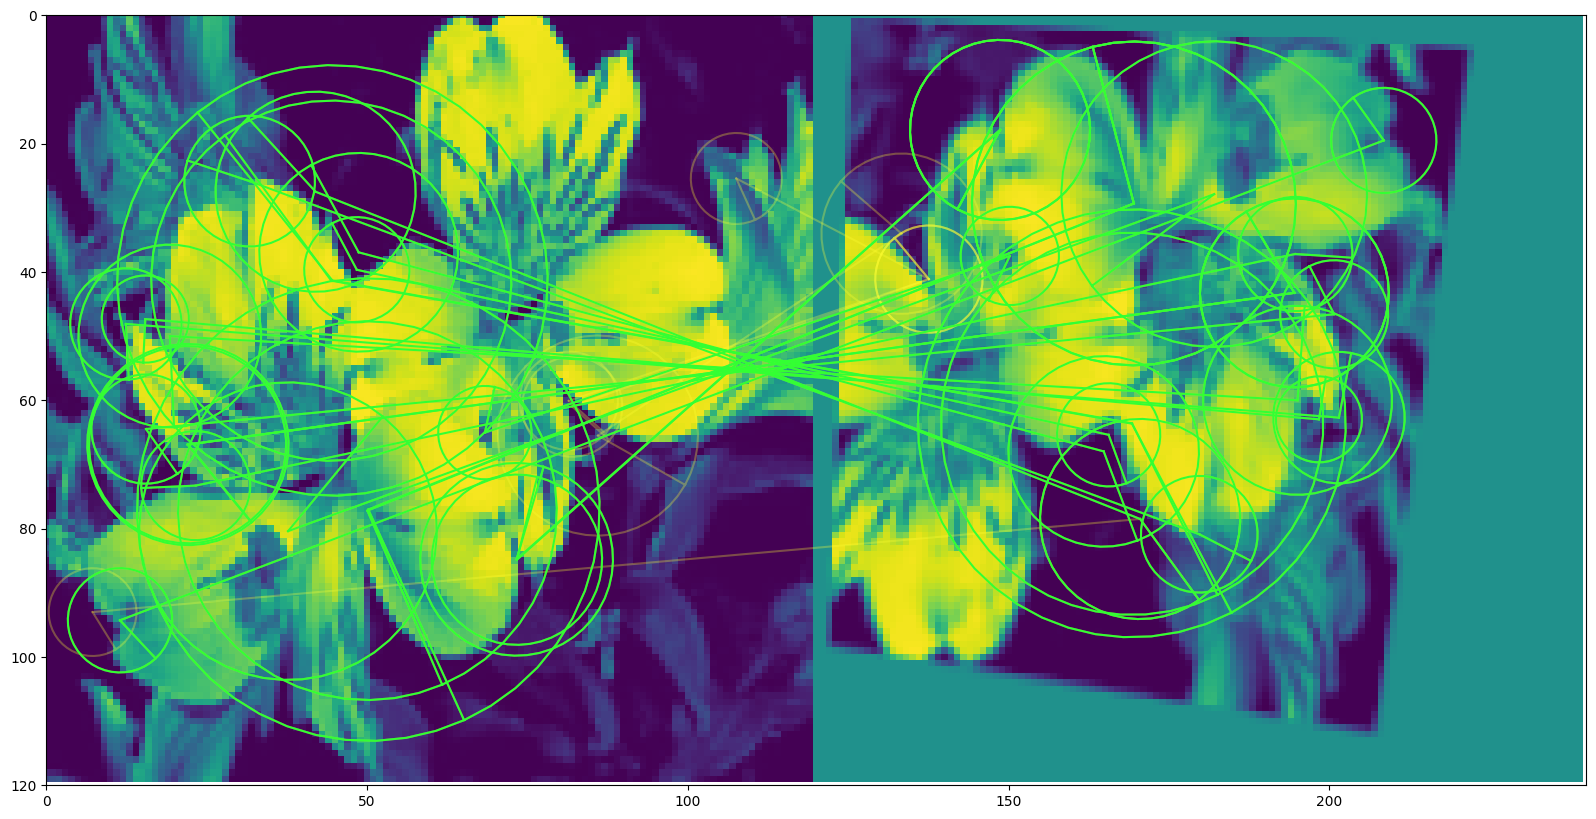

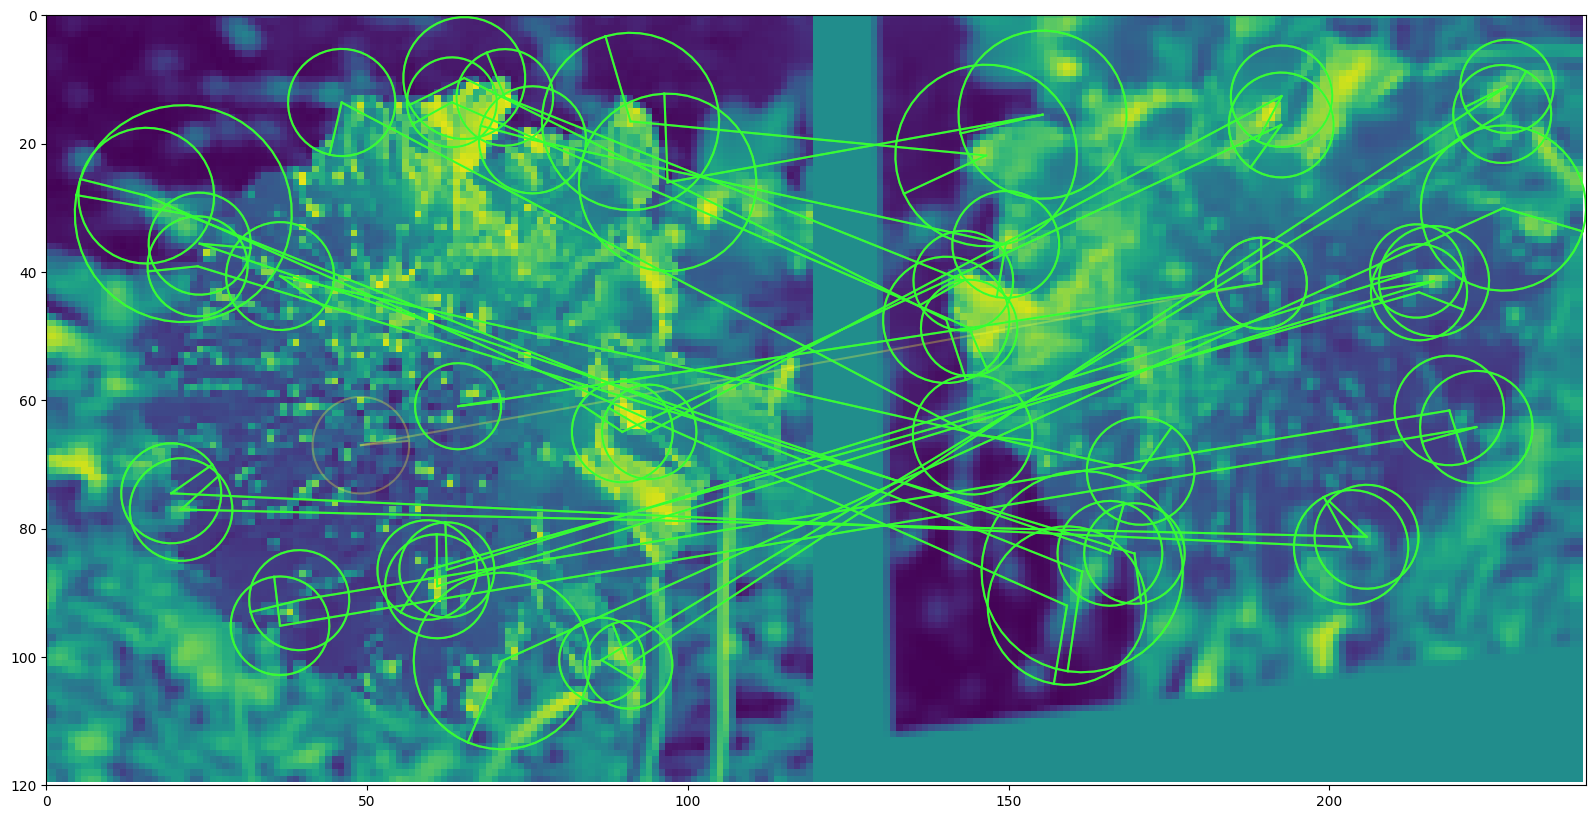

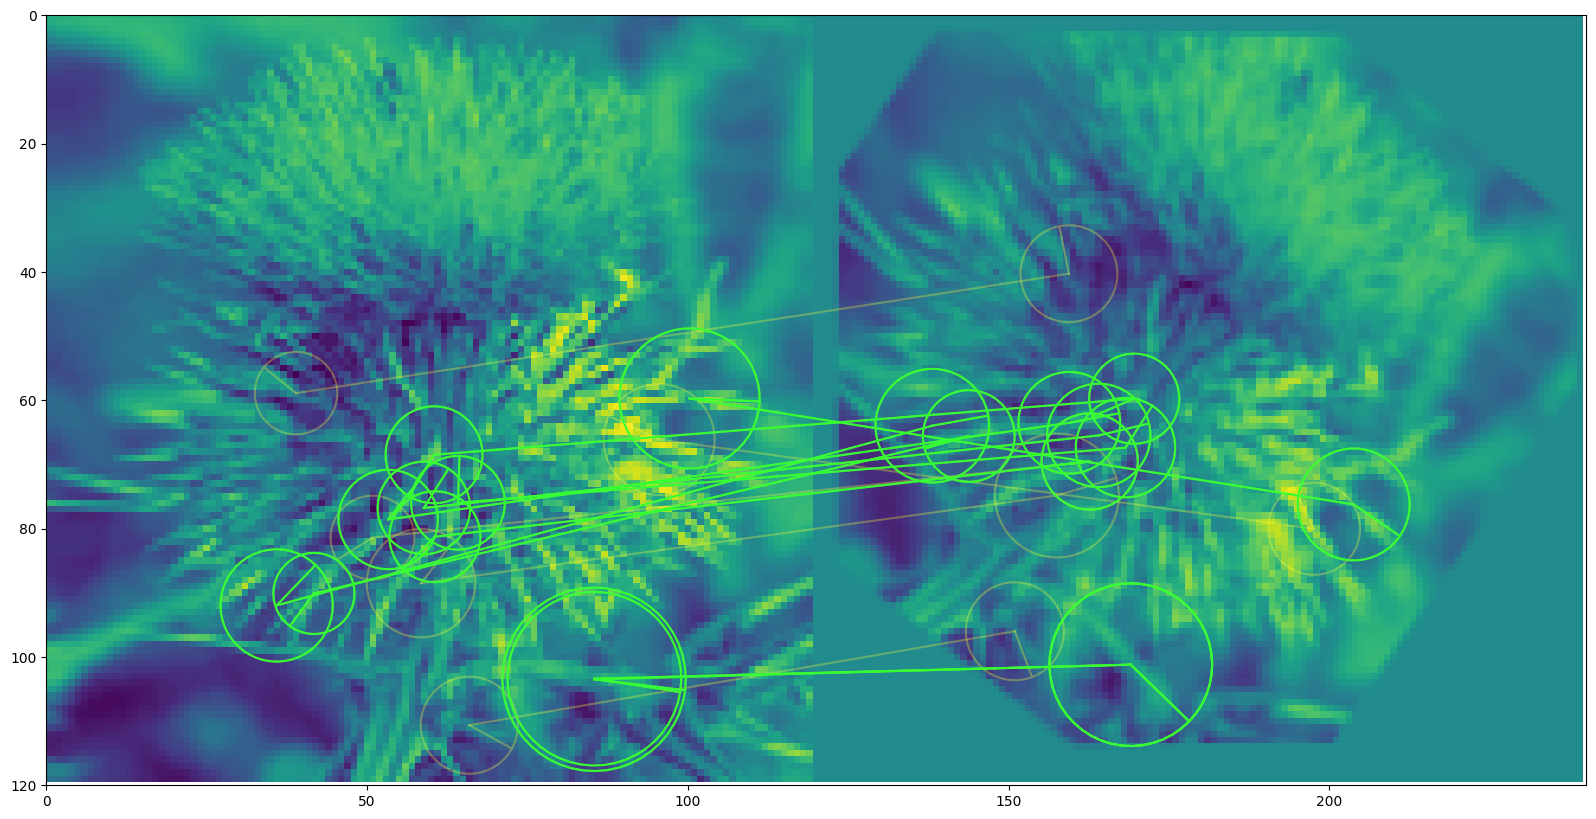

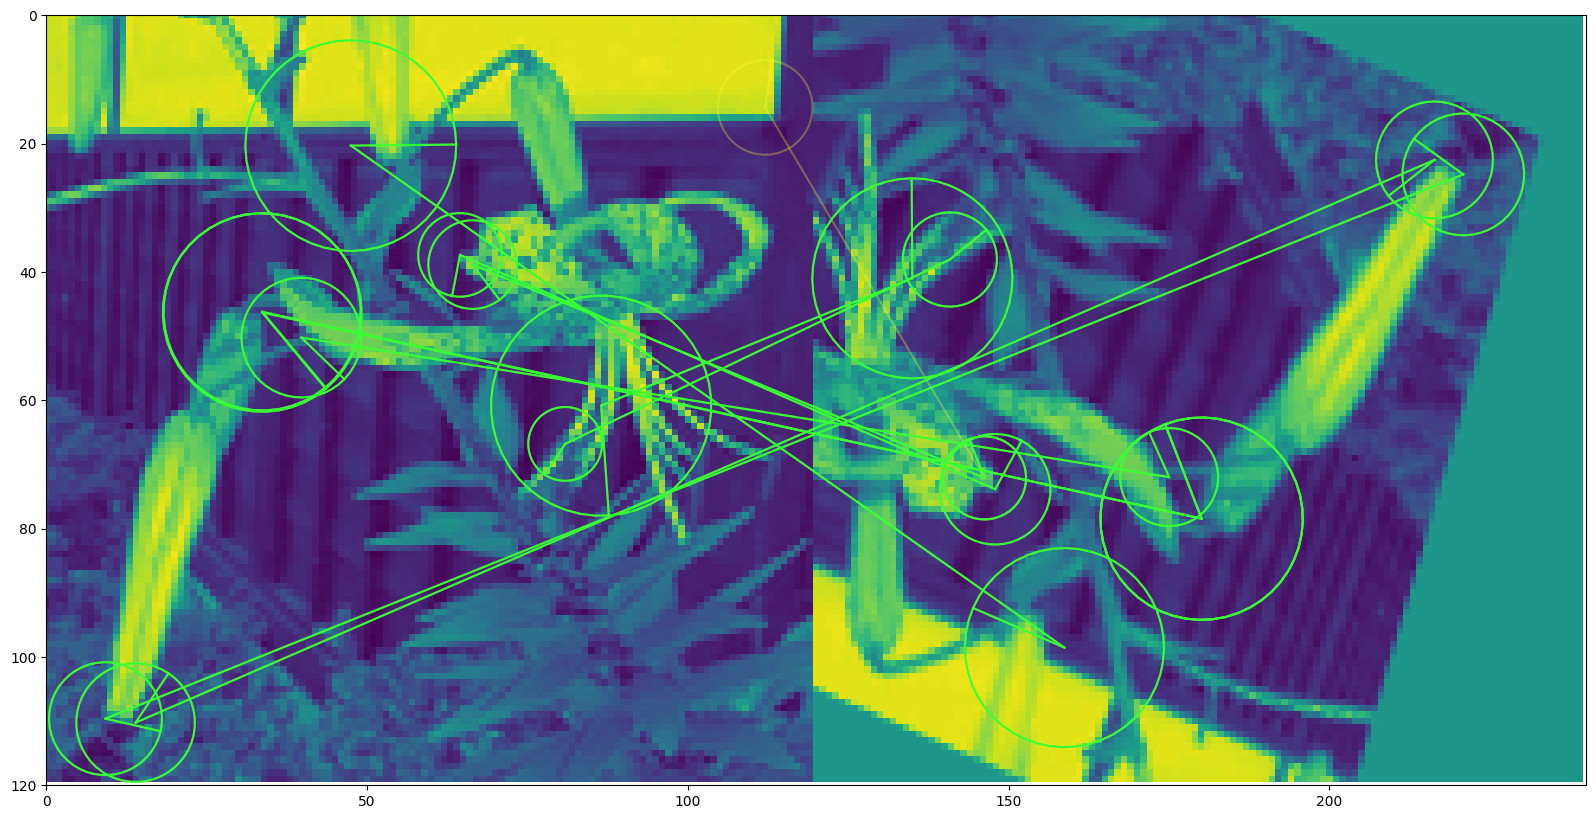

In [4]:
params_lists.aug_list.data_keys =["input"]
aug_list = params_lists.aug_list

acertos = 0
total = 0
from tqdm.notebook import tqdm
pbar =  tqdm(testloader)
for imgs_batch,labels_batch in pbar:# itera em todo dataset
    imgs_batch = imgs_batch.to(sp.device)
    
    params_item = next(params_lists)
    timg_gray_t = aug_list(imgs_batch,params=params_item)
    repo_lafs_desc= detect_extract_feat_in_batch(timg_gray_t,detector,descriptor,TS.PS)
        
    for i,img_gray in enumerate(imgs_batch):# itera em cada batch

        match_index = matching_imagens(img_gray,timg_gray_t,repo_lafs_desc)
        # print("match_index: ",match_index," i: ",i)
        total+=1
        if match_index == i:
            acertos += 1
        pbar.set_description(f"acertos/total: {acertos}/{total}  ")
print("acertos: ",acertos)